<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

# Researching the Momentum Factor

Momentum investing says that excess returns can be generated by buying recent winners and selling recent losers. In this notebook we'll use Alphalens, an open-source research tool created by Quantopian, to test the momentum factor on our universe of demo stocks. This will help us determine whether we have a profitable idea before turning to a full backtest.  

First, load your historical data into pandas.

In [1]:
from quantrocket.history import get_historical_prices
prices = get_historical_prices("demo-stocks-1d", start_date="2010-01-01", fields=["Close"])
prices.head()

ConId             265598     267892     274105     3691937    15124833   \
Field Date                                                                
Close 2010-01-04     30.575      53.59     11.525     133.90      7.640   
      2010-01-05     30.625      52.24     11.795     134.69      7.360   
      2010-01-06     30.140      52.45     11.710     132.25      7.615   
      2010-01-07     30.085      51.73     11.675     130.00      7.485   
      2010-01-08     30.285      51.50     11.640     133.52      7.615   

ConId             41498671   208813719  
Field Date                              
Close 2010-01-04      30.99    313.690  
      2010-01-05      32.71    312.305  
      2010-01-06      32.35    304.435  
      2010-01-07      31.39    297.345  
      2010-01-08      32.68    301.310

Next, we use closing prices to calculate our momentum factor, the predictive factor we'll pass to Alphalens. We calculate momentum using a twelve-month window but excluding the most recent month, as commonly recommended by academic papers. 

In [2]:
closes = prices.loc["Close"]

MOMENTUM_WINDOW = 252 # 12 months = 252 trading days
RANKING_PERIOD_GAP = 22 # 1 month = 22 trading days
earlier_closes = closes.shift(MOMENTUM_WINDOW)
later_closes = closes.shift(RANKING_PERIOD_GAP)
returns = (later_closes - earlier_closes) / earlier_closes

Now that we have the twelve-month returns, we prepare the data for Alphalens by shifting the returns forward one period to avoid lookahead bias (since we cannot use today's returns to predict today's prices): 

In [3]:
returns = returns.shift()
returns.tail()

ConId,265598,267892,274105,3691937,15124833,41498671,208813719
Date,,,,,,,
2018-10-30,0.379638,-0.190996,0.044825,0.828403,0.907938,-0.145390,0.168032
2018-10-31,0.354007,-0.175278,0.030270,0.803124,0.886021,-0.167623,0.168372
2018-11-01,0.344416,-0.221005,0.013494,0.813441,0.941811,-0.182283,0.169877
2018-11-02,0.373839,-0.233200,0.008344,0.786125,0.904747,-0.185915,0.158302
2018-11-05,0.380465,-0.247973,0.010935,0.784614,0.891682,-0.209302,0.161615


We have a wide-form DataFrame but Alphalens expects it to be stacked:

In [4]:
returns = returns.stack()
returns.head()

Date        ConId   
2011-01-04  265598      0.478332
            267892      0.091062
            274105      0.375271
            3691937     0.318521
            15124833    2.742147
dtype: float64

Now we're ready to pass our data to Alphalens and check out the returns tear sheet. In addition to passing Alphalens a predictive factor, we also need to provide pricing data so that Alphalens can tell us whether the factor predicted subsequent prices.

> Note: Sometimes Alphalens takes awhile to generate its charts and may not be suitable for large amounts of data. Modeling with Alphalens is not a required step. Both Moonshot and Zipline can handle large universes.

In [5]:
import alphalens

Dropped 0.5% entries from factor data: 0.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Returns Analysis


,1D,5D,10D
Ann. alpha,0.118,0.107,0.095
beta,-0.091,-0.114,-0.134
Mean Period Wise Return Top Quantile (bps),1.136,1.217,0.917
Mean Period Wise Return Bottom Quantile (bps),-0.852,-0.913,-0.689
Mean Period Wise Spread (bps),1.988,1.952,1.404


/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/datetimes.py:962: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


<Figure size 432x288 with 0 Axes>

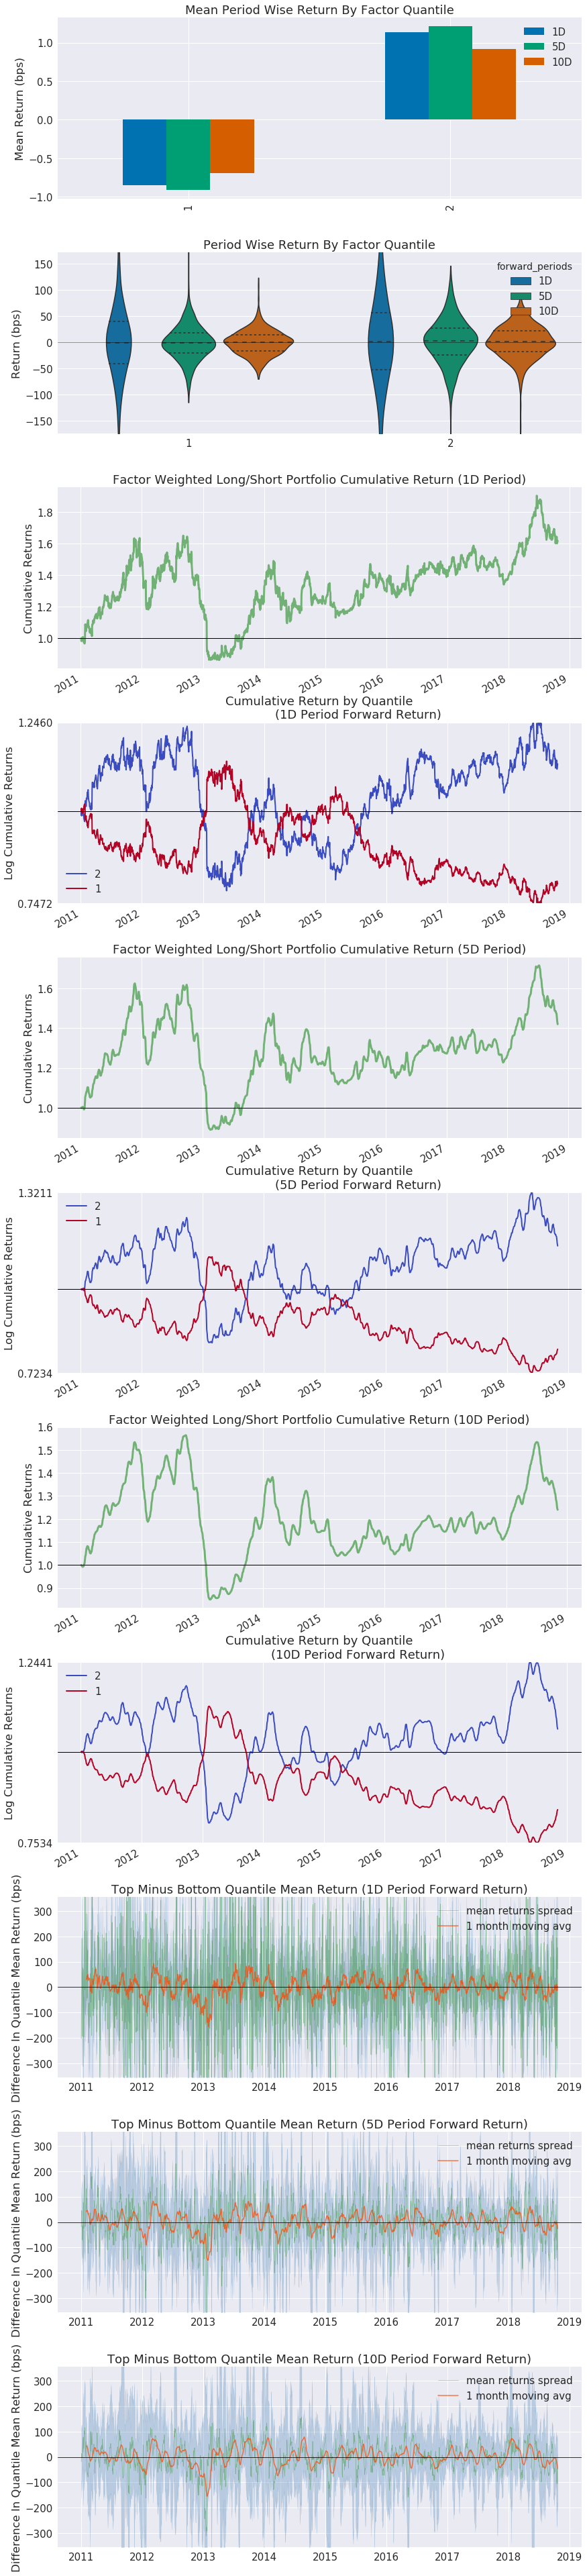

In [6]:
# For a very small demo universe, you might only want 2 quantiles 
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(returns, closes, quantiles=2)
alphalens.tears.create_returns_tear_sheet(factor_data)

For a predictive factor, the higher quantiles should perform better than the lower quantiles, and the cumulative return charts should trend upward.

***

## *Next Up*

Part 5: [Moonshot Strategy Code](Part5-Moonshot-Strategy-Code.ipynb)